In [1]:
%matplotlib inline
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=1

import os
import cv2
import numpy as np
import torch
from torch.autograd import Variable
import quat_math
import pickle
import glob

from PIL import Image
import scipy.io as scio
from functools import partial
from object_pose_utils.utils import to_np, to_var
from object_pose_utils.utils.display import *

import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = 20, 12
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

import warnings
warnings.filterwarnings('ignore')

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=1


## Select Object Indices of Interest

| Object Indices |[]()|[]()|
|---|---|---|
| __1.__ 002_master_chef_can | __8.__ 009_gelatin_box      | __15.__ 035_power_drill       |
| __2.__ 003_cracker_box     | __9.__ 010_potted_meat_can  | __16.__ 036_wood_block        |
| __3.__ 004_sugar_box       | __10.__ 011_banana          | __17.__ 037_scissors          |
| __4.__ 005_tomato_soup_can | __11.__ 019_pitcher_base    | __18.__ 040_large_marker      |
| __5.__ 006_mustard_bottle  | __12.__ 021_bleach_cleanser | __19.__ 051_large_clamp       |
| __6.__ 007_tuna_fish_can   | __13.__ 024_bowl            | __20.__ 052_extra_large_clamp |
| __7.__ 008_pudding_box     | __14.__ 025_mug             | __21.__ 061_foam_brick        |

## YCB Dataset

In [2]:
dataset_root = '/ssd0/datasets/ycb/YCB_Video_Dataset'

object_list = list(range(1,22))

with open('{0}/image_sets/classes.txt'.format(dataset_root)) as f:                                    
    classes = f.read().split()
classes.insert(0, '__background__')

## Distribution Estimators

In [3]:
from object_pose_utils.utils.pose_processing import quatAngularDiffBatch

In [4]:
from object_pose_utils.utils.interpolation import BinghamInterpolation

if(False):
    from object_pose_utils.utils.bingham import isobingham_likelihood

    sigmas_data = np.load('/home/bokorn/src/generic_pose/generic_pose/notebooks/fc6_sigma.npz', allow_pickle=True)
    sigmas = sigmas_data['sigmas'].item()

    def bing_fixed(res, obj):
        feat, pred_q, pred_t = res
        bingham = BinghamInterpolation(pred_q.unsqueeze(0).cuda(), 
                                       torch.ones(1).cuda(), 
                                       sigma=torch.Tensor([sigmas[obj.item()]]).cuda())
        return bingham, pred_q, pred_t

In [5]:
from generic_pose.models.bingham_networks import IsoBingham
from generic_pose.losses.bingham_loss import isoLikelihood

if(True):
    #feature_size = 1024
    feature_size = 4096
    #iso_model_checkpoint_pattern = '/scratch/bokorn/results/log_lik/posecnn_fc6_iso/**/weights/checkpoint_*.pth'
    #iso_model_checkpoint = sorted(glob.glob(iso_model_checkpoint_pattern,
    #                                        recursive=True))[-1]
    iso_model_checkpoint = '/scratch/bokorn/results/log_lik/posecnn_fc6_iso/lr_1e-6/2019-09-07_16-10-58/weights/best_quat.pth'
    print(glob.glob('/'.join(iso_model_checkpoint.split('/')[:-1]) + '/*', recursive=True))

    iso_estimator = IsoBingham(feature_size, len(object_list))
    iso_estimator.load_state_dict(torch.load(iso_model_checkpoint))
    iso_estimator.eval()
    iso_estimator.cuda()

    def bing_iso(res, obj):
        feat, pred_q, pred_t = res
        
        feat = torch.Tensor(feat).unsqueeze(0).cuda()
        mean_est = torch.Tensor(pred_q).unsqueeze(0).cuda()
        df_obj = torch.LongTensor(obj-1).unsqueeze(0).cuda()
        sig_est = iso_estimator(feat.unsqueeze(0).cuda(), df_obj)
        lik_est = isoLikelihood(mean_q=mean_est[0], 
                                sig=sig_est[0,0])
        
        return lik_est, pred_q, pred_t

['/scratch/bokorn/results/log_lik/posecnn_fc6_iso/lr_1e-6/2019-09-07_16-10-58/weights/best_quat.pth', '/scratch/bokorn/results/log_lik/posecnn_fc6_iso/lr_1e-6/2019-09-07_16-10-58/weights/checkpoint_524000.pth']


In [6]:
TEST_SET = False

if(TEST_SET):
    test_data = np.load('test_quats.npz', allow_pickle=True)

    df_gt=test_data['df_gt'].item()
    df_est=test_data['df_est'].item()
    pcnn_gt=test_data['pcnn_gt'].item()
    pcnn_est=test_data['pcnn_est'].item()

else:
    val_data = np.load('val_quats.npz', allow_pickle=True) 
    
    df_gt=val_data['df_gt'].item()
    df_est=val_data['df_est'].item()
    pcnn_gt=val_data['pcnn_gt'].item()
    pcnn_est=val_data['pcnn_est'].item()


In [7]:
loss_all, lik_all = isoLoss(q_df, sig_df, q_gt_df, return_all=True)
loss, lik = isoLoss(q_df, sig_df, q_gt_df, return_all=False)

NameError: name 'isoLoss' is not defined

In [ ]:
from object_pose_utils.utils.subrandom import subrandom
from generic_pose.losses.bingham_loss import isoLoss
from tqdm import tqdm_notebook as tqdm

sigma_lims = [0.001, 1000]
num_samples = 100

sigmas = subrandom(num_samples)*(sigma_lims[1]-sigma_lims[0]) + sigma_lims[0]
df_losses = {obj:[] for obj in object_list}
df_likelihoods = {obj:[] for obj in object_list}

pc_losses = {obj:[] for obj in object_list}
pc_likelihoods = {obj:[] for obj in object_list}

for obj in tqdm(object_list):
    q_gt_df = df_gt[obj].cuda()
    q_df = df_est[obj].cuda()
    
    q_gt_pc = pcnn_gt[obj].cuda()
    q_pc = pcnn_est[obj].cuda() 
    for j, sig in enumerate(tqdm(sigmas)):
        sig_df = torch.Tensor([[sig]]).cuda().repeat(q_gt_df.shape[0], 1)
        df_loss, df_lik = isoLoss(q_df, sig_df, q_gt_df)
        df_losses[obj].append(df_loss)
        df_likelihoods[obj].append(df_lik)
        
        sig_pc = torch.Tensor([[sig]]).cuda().repeat(q_gt_pc.shape[0], 1)
        pc_loss, pc_lik = isoLoss(q_pc, sig_pc, q_gt_pc)
        pc_losses[obj].append(pc_loss)
        pc_likelihoods[obj].append(pc_lik)
    
    df_likelihoods[obj] = to_np(torch.stack(df_likelihoods[obj]))
    df_losses[obj] = to_np(torch.stack(df_losses[obj])) 
    pc_likelihoods[obj] = to_np(torch.stack(pc_likelihoods[obj]))
    pc_losses[obj] = to_np(torch.stack(pc_losses[obj])) 

-11.597784

In [93]:
obj = 1
j = 0
q_gt_df = df_gt[obj].cuda()
q_df = df_est[obj].cuda()
sig = 53.06759009009921
sig_df = torch.Tensor([[sig]]).cuda().repeat(q_gt_df.shape[0], 1)
df_loss, df_lik = isoLoss(q_df[j,:].unsqueeze(0),
                          sig_df[j,:].unsqueeze(0),
                          q_gt_df[j,:].unsqueeze(0))

In [98]:
df_lik*2

tensor(45.3374, device='cuda:0')

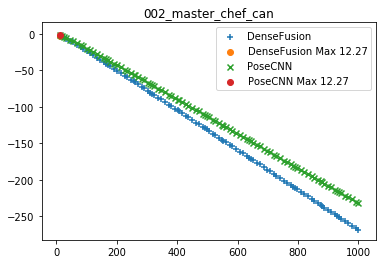

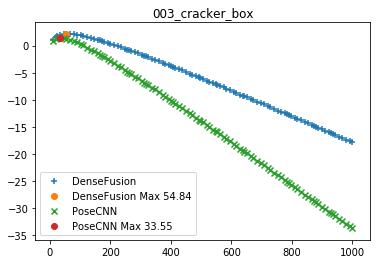

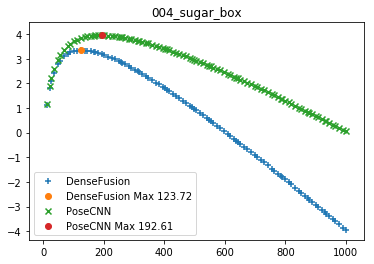

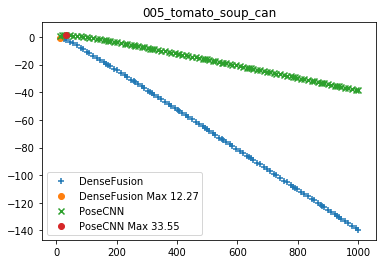

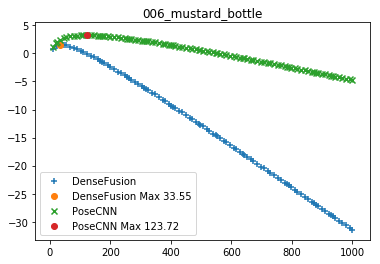

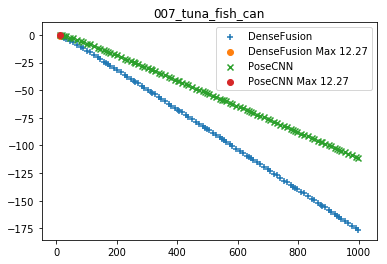

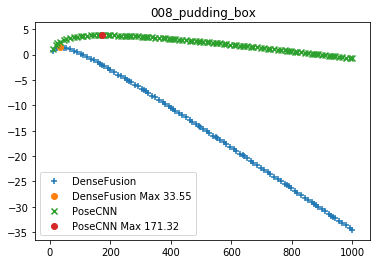

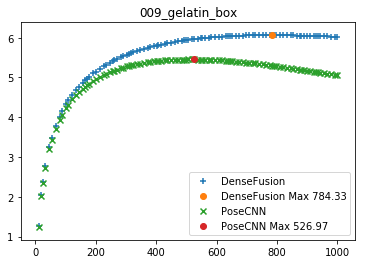

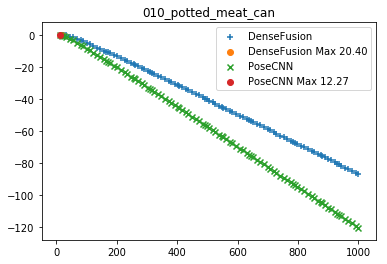

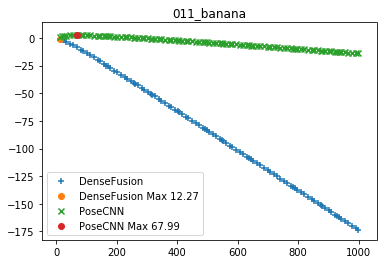

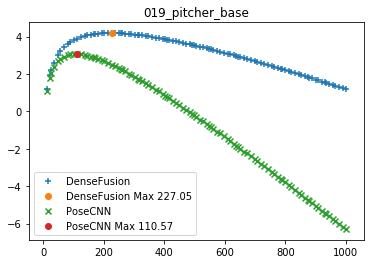

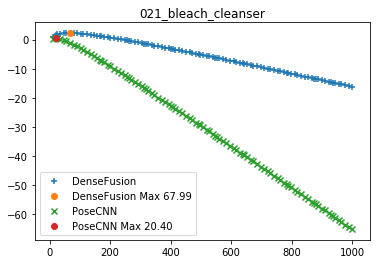

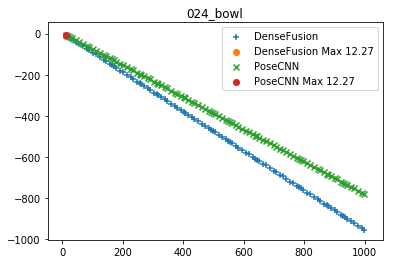

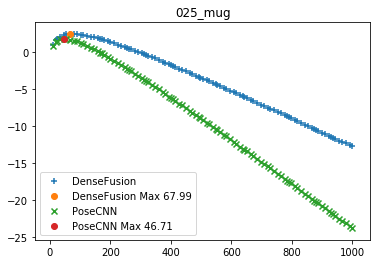

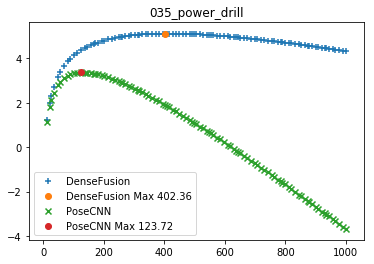

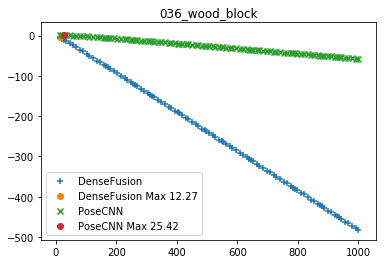

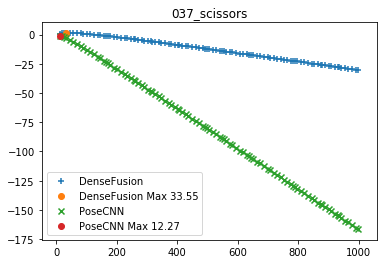

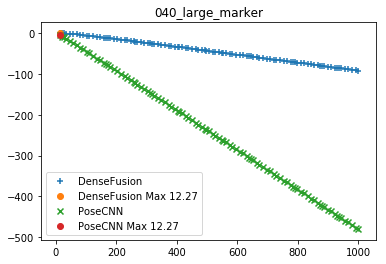

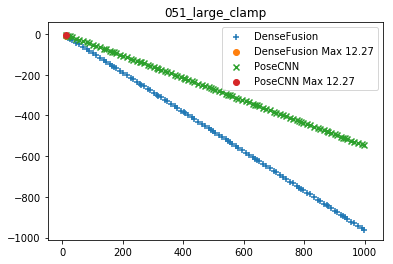

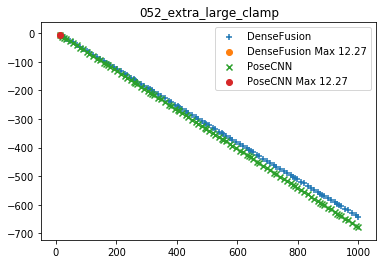

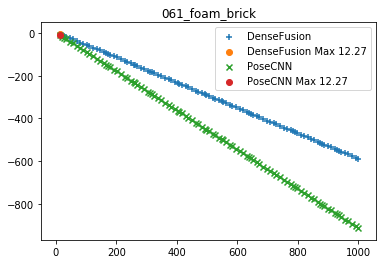

In [76]:
df_max_sigmas = {}
pc_max_sigmas = {}

for obj in object_list:
    plt.title(classes[obj])
    df_max = np.argmax(-df_losses[obj])
    df_max_sigmas[obj] = sigmas[df_max]
    plt.scatter(sigmas, -df_losses[obj], marker='+', label='DenseFusion')
    plt.scatter(sigmas[df_max], -df_losses[obj][df_max], label='DenseFusion Max {:.2f}'.format(sigmas[df_max]))
    pc_max = np.argmax(-pc_losses[obj])
    pc_max_sigmas[obj] = sigmas[pc_max]
    plt.scatter(sigmas, -pc_losses[obj], marker='x', label='PoseCNN')
    plt.scatter(sigmas[pc_max], -pc_losses[obj][pc_max], label='PoseCNN Max {:.2f}'.format(sigmas[pc_max]))
    plt.legend()
    plt.show()

In [100]:
#np.savez('df_test_sigmas.npz', single_sigma=df_max_sigmas)
#np.savez('pc_test_sigmas.npz', sigma=pc_max_sigmas)
#np.savez('test_sigma_results.npz', 
#         sigmas = sigmas,
#         df_losses = df_losses,
#         df_likelihoods = df_likelihoods,
#         pc_losses = pc_losses,
#         pc_likelihoods = pc_likelihoods) 

In [59]:
df_sigmas = np.load('/home/bokorn/src/DenseFusion/df_orig_sigmas.npz', allow_pickle=True)['single_sigma'].item()
pc_sigmas = np.load('../notebooks/fc6_sigma.npz', allow_pickle=True)['sigmas'].item()

In [86]:
np.argmin(np.abs(sigmas - 53))
sigmas[19]

54.83889276993902

In [73]:
pc_max_sigmas

{1: 220.25169290835154,
 2: 185.80987360157158,
 3: 116.9262349880116,
 4: 116.9262349880116,
 5: 289.1353315219115,
 6: 95.6400200220408,
 7: 254.69351221513153,
 8: 228.38230353351315,
 9: 108.79562436284999,
 10: 39.91198574929002,
 11: 74.35380505607002,
 12: 116.9262349880116,
 13: 143.23744366962998,
 14: 61.19820071526081,
 15: 130.0818393288208,
 16: 5.470166442510036,
 17: 61.19820071526081,
 18: 5.470166442510036,
 19: 39.91198574929002,
 20: 39.91198574929002,
 21: 151.3680542947916}

In [72]:
pc_sigmas

{1: 0.0027629295374846374,
 2: 0.0027629295374846374,
 3: 0.004795584226429728,
 4: 0.0027629295374846374,
 5: 0.0027629295374846374,
 6: 0.0027629295374846374,
 7: 0.0027629295374846374,
 8: 0.01011714328948149,
 9: 0.0027629295374846374,
 10: 0.004795584226429728,
 11: 0.0027629295374846374,
 12: 0.0080844886005364,
 13: 0.0027629295374846374,
 14: 0.004795584226429728,
 15: 0.0027629295374846374,
 16: 0.0080844886005364,
 17: 0.0027629295374846374,
 18: 0.0027629295374846374,
 19: 0.0080844886005364,
 20: 0.0027629295374846374,
 21: 0.01011714328948149}